# Importing modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

# Fearture engineering

### Columns to drop

In [2]:
columns_to_drop=[
    'transaction_id',
    'customer_unique_id',
    'anomaly_types',
    'created_at',
    'updated_at',
    'bill_date',
    'business_date',
    'rule_id',
    'rule_type',
    'item_code',
    'sku_category_code',
    'category_code',
    'store_id',
    'activity_id',
    'funding_partner_id'
]

# Preprocessing Function

In [3]:
def preprocessing(df):
    df = df.drop(columns=columns_to_drop)
    
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    
    df['hours'] = df['transaction_date'].dt.hour
    df['day_of_week'] = df['transaction_date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df = df.drop(columns=['transaction_date'])
    
    return df

# Training Function

In [4]:
def training(df):
    
    df = preprocessing(df)
    
    X = df.drop(columns=['is_anomaly'])
    y = df['is_anomaly']
    
    cat_cols = X.select_dtypes(include=['str', 'object']).columns
    
    neg = (y == 0).sum()
    pos = (y == 1).sum()
    
    scale_weight = neg/pos
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)
    
    model = CatBoostClassifier(class_weights=[1, scale_weight], verbose=0)
    
    model.fit(X_train, y_train, cat_features=cat_cols.tolist())
    
    y_prob = model.predict_proba(X_test)[:,1]
    threshold = 0.3
    y_pred = (y_prob > threshold).astype(int)

    
    # decile_bins = np.percentile(y_prob, [10,20,30,40,50,60,70,80,90])
    
    # def assign_decile(prob, bins):
    #     for i, cutoff in enumerate(bins):
    #         if prob <= cutoff:
    #             return f"D{i+1}"
    #     return "D10"

    # result_df = pd.DataFrame({
    #     "actual": y_test.values,
    #     "probability": y_prob,
    #     "predicted": y_pred
    # })

    # result_df["decile"] = result_df["probability"].apply(
    #     lambda x: assign_decile(x, decile_bins)
    # )
    
    # def assign_severity(decile):
    #     if decile == "D10":
    #         return "Very High Risk"
    #     elif decile in ["D8", "D9"]:
    #         return "High Risk"
    #     elif decile in ["D5", "D6", "D7"]:
    #         return "Medium Risk"
    #     else:
    #         return "Low Risk"

    # result_df["severity"] = result_df["decile"].apply(assign_severity)
    
    # ACTION_ORDER = ["Very High Risk", "High Risk", "Medium Risk", "Low Risk"]

    # print("\nNon-Anomalies Distribution")
    # good_table = (
    #     result_df[result_df["actual"] == 0]["severity"]
    #     .value_counts()
    #     .reindex(ACTION_ORDER, fill_value=0)
    #     .to_frame("Count")
    # )
    # good_table["%"] = (
    #     good_table["Count"] / good_table["Count"].sum() * 100
    # ).round(2)
    # print(good_table)

    # print("\nAnomalies Distribution")
    # bad_table = (
    #     result_df[result_df["actual"] == 1]["severity"]
    #     .value_counts()
    #     .reindex(ACTION_ORDER, fill_value=0)
    #     .to_frame("Count")
    # )
    # bad_table["%"] = (
    #     bad_table["Count"] / bad_table["Count"].sum() * 100
    # ).round(2)
    # print(bad_table)

    # # -----------------------------
    # # Decile Performance Table
    # # -----------------------------
    # decile_summary = (
    #     result_df.groupby("decile")
    #     .agg(
    #         total=("actual","count"),
    #         bad=("actual","sum")
    #     )
    # )

    # decile_summary["bad_rate"] = (
    #     decile_summary["bad"] / decile_summary["total"]
    # ).round(4)

    # print("\nDecile Performance Table")
    # print(decile_summary.sort_index())

    return model, y_test, y_pred, y_prob

# Metrics

In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from scipy.stats import ks_2samp

def metrics(y_test, y_pred, y_prob):
    print("\nModel Metrics")
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print(f'Gini: {2*roc_auc_score(y_test, y_prob) - 1}')
    print(f'KS: {ks_2samp(y_prob[y_test==0], y_prob[y_test==1]).statistic}')
    print("PR AUC:", average_precision_score(y_test, y_prob))
    print("F1:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Decile

In [8]:
def decile_cal(y_test, y_prob, y_pred):
    decile_bins = np.percentile(y_prob, [10,20,30,40,50,60,70,80,90])
    
    def assign_decile(prob, bins):
        for i, cutoff in enumerate(bins):
            if prob <= cutoff:
                return f"D{i+1}"
        return "D10"

    result_df = pd.DataFrame({
        "actual": y_test.values,
        "probability": y_prob,
        "predicted": y_pred
    })

    result_df["decile"] = result_df["probability"].apply(
        lambda x: assign_decile(x, decile_bins)
    )
    
    def assign_severity(decile):
        if decile == "D10":
            return "Very High Risk"
        elif decile in ["D8", "D9"]:
            return "High Risk"
        elif decile in ["D5", "D6", "D7"]:
            return "Medium Risk"
        else:
            return "Low Risk"

    result_df["severity"] = result_df["decile"].apply(assign_severity)
    
    ACTION_ORDER = ["Very High Risk", "High Risk", "Medium Risk", "Low Risk"]

    print("\nNon-Anomalies Distribution")
    good_table = (
        result_df[result_df["actual"] == 0]["severity"]
        .value_counts()
        .reindex(ACTION_ORDER, fill_value=0)
        .to_frame("Count")
    )
    good_table["%"] = (
        good_table["Count"] / good_table["Count"].sum() * 100
    ).round(2)
    print(good_table)

    print("\nAnomalies Distribution")
    bad_table = (
        result_df[result_df["actual"] == 1]["severity"]
        .value_counts()
        .reindex(ACTION_ORDER, fill_value=0)
        .to_frame("Count")
    )
    bad_table["%"] = (
        bad_table["Count"] / bad_table["Count"].sum() * 100
    ).round(2)
    print(bad_table)

    # -----------------------------
    # Decile Performance Table
    # -----------------------------
    decile_summary = (
        result_df.groupby("decile")
        .agg(
            total=("actual","count"),
            bad=("actual","sum")
        )
    )

    decile_summary["bad_rate"] = (
        decile_summary["bad"] / decile_summary["total"]
    ).round(4)

    print("\nDecile Performance Table")
    print(decile_summary.sort_index())
    
    return result_df

# Load Data

In [9]:
print("Loading datasets...")

accu_df = pd.read_csv("Datasets/synthetic_accural_data.csv")
redm_df = pd.read_csv("Datasets/synthetic_redeem_data.csv")

print("Datasets loaded.")

Loading datasets...
Datasets loaded.


# EDA

In [14]:
accu_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8219 entries, 0 to 8218
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_id            8219 non-null   str    
 1   customer_unique_id        8219 non-null   str    
 2   transaction_date          8219 non-null   str    
 3   transaction_type          8219 non-null   str    
 4   points                    8219 non-null   float64
 5   partner_id                8219 non-null   int64  
 6   store_id                  8219 non-null   int64  
 7   opening_balance           8219 non-null   float64
 8   closing_balance           8219 non-null   float64
 9   amount                    8219 non-null   float64
 10  is_anomaly                8219 non-null   int64  
 11  anomaly_types             1578 non-null   str    
 12  country_code              8219 non-null   int64  
 13  activity_id               8219 non-null   int64  
 14  category_code      

In [16]:
redm_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2364 entries, 0 to 2363
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_id            2364 non-null   str    
 1   customer_unique_id        2364 non-null   str    
 2   transaction_date          2364 non-null   str    
 3   transaction_type          2364 non-null   str    
 4   points                    2364 non-null   float64
 5   partner_id                2364 non-null   int64  
 6   store_id                  2364 non-null   int64  
 7   opening_balance           2364 non-null   float64
 8   closing_balance           2364 non-null   float64
 9   amount                    2364 non-null   float64
 10  is_anomaly                2364 non-null   int64  
 11  anomaly_types             727 non-null    str    
 12  country_code              2364 non-null   int64  
 13  activity_id               2364 non-null   int64  
 14  category_code      

### Correlation Matrix

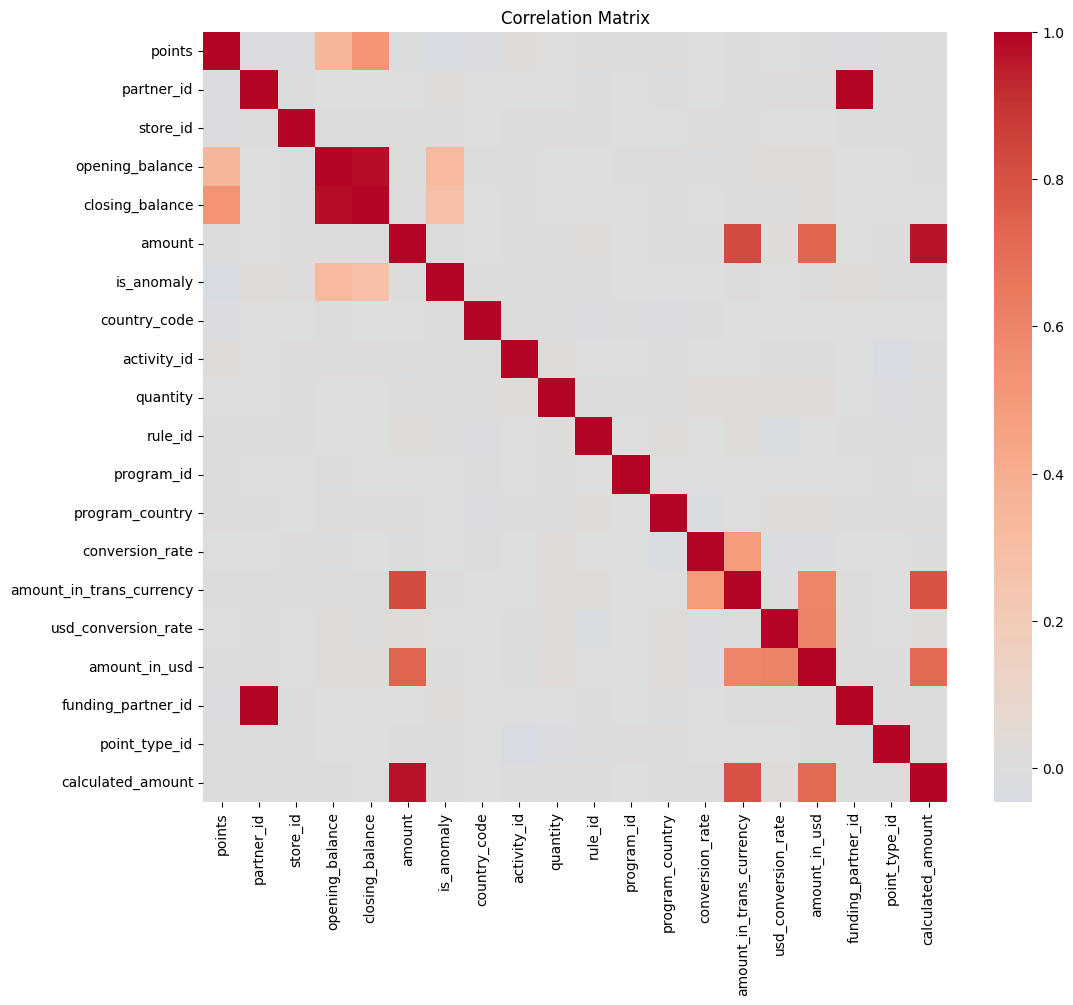

In [ ]:
num_cols = accu_df.select_dtypes(include=np.number).columns

plt.figure(figsize=(12,10))
sns.heatmap(accu_df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

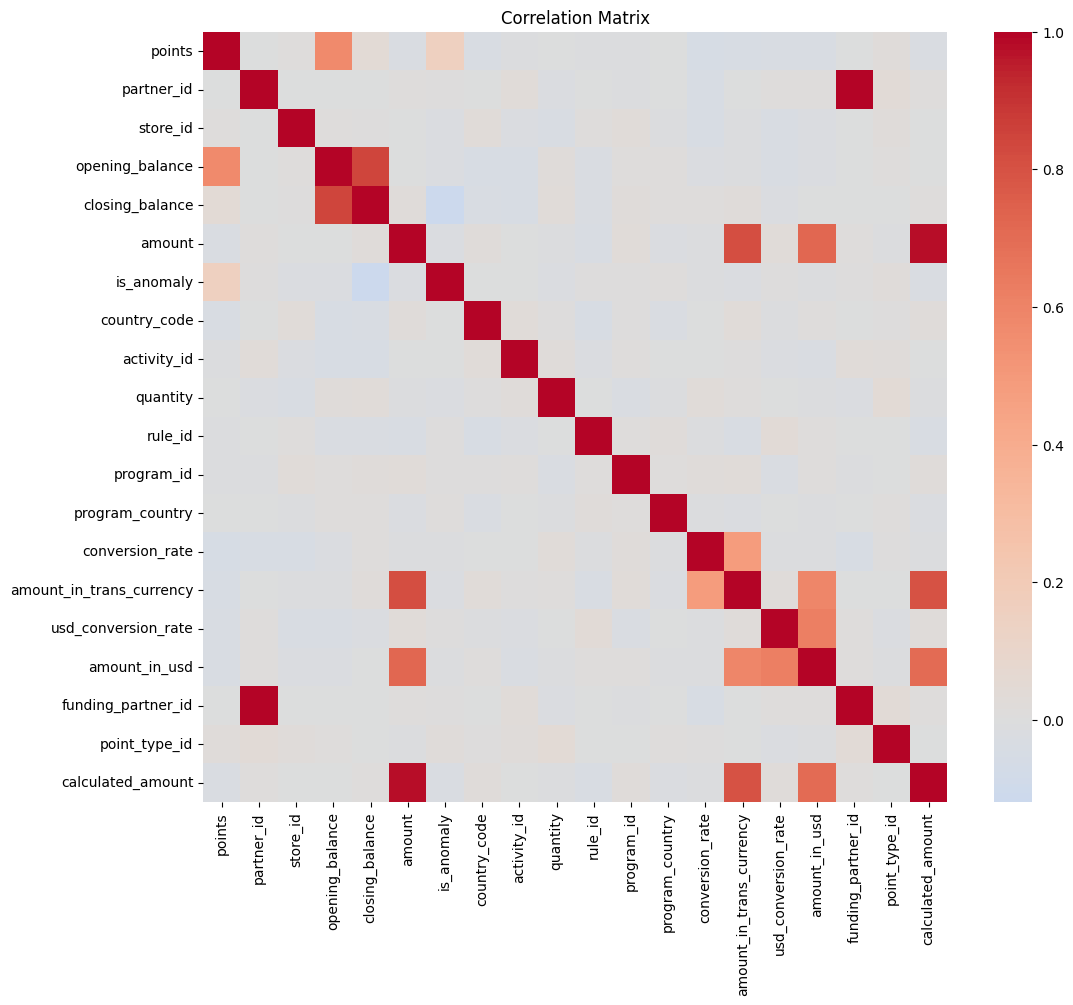

In [49]:
num_cols = redm_df.select_dtypes(include=np.number).columns

plt.figure(figsize=(12,10))
sns.heatmap(redm_df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

In [57]:
numeric_cols_a = accu_df.select_dtypes(include=np.number)

corr_with_target_a = numeric_cols_a.corr()["is_anomaly"].sort_values(ascending=False)

print(corr_with_target_a)


is_anomaly                  1.000000
opening_balance             0.314204
closing_balance             0.275034
funding_partner_id          0.018009
partner_id                  0.018009
activity_id                 0.015628
store_id                    0.013315
amount_in_usd               0.012625
amount_in_trans_currency    0.011069
quantity                    0.010194
country_code                0.007995
point_type_id               0.007969
calculated_amount           0.006574
amount                      0.006337
usd_conversion_rate         0.001761
conversion_rate            -0.001584
program_id                 -0.003677
program_country            -0.003881
rule_id                    -0.007656
points                     -0.045365
Name: is_anomaly, dtype: float64


In [58]:
numeric_cols_r = redm_df.select_dtypes(include=np.number)

corr_with_target_r = numeric_cols_r.corr()["is_anomaly"].sort_values(ascending=False)

print(corr_with_target_r)


is_anomaly                  1.000000
points                      0.152733
point_type_id               0.018352
program_country             0.007526
usd_conversion_rate         0.005515
rule_id                     0.005341
funding_partner_id          0.004415
partner_id                  0.004415
program_id                  0.003498
activity_id                 0.002691
country_code               -0.001930
conversion_rate            -0.008333
amount_in_usd              -0.009829
opening_balance            -0.015567
amount_in_trans_currency   -0.017034
quantity                   -0.019084
store_id                   -0.021089
amount                     -0.021727
calculated_amount          -0.024140
closing_balance            -0.119369
Name: is_anomaly, dtype: float64


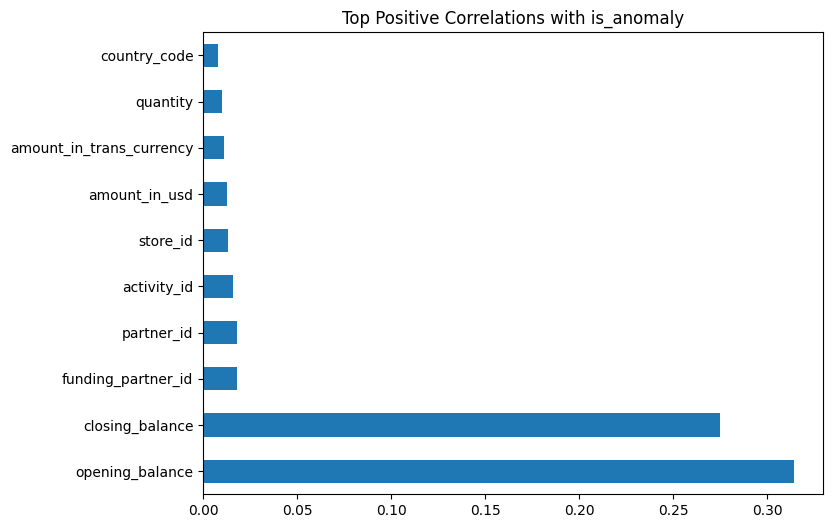

In [59]:
plt.figure(figsize=(8,6))
corr_with_target_a.drop("is_anomaly").head(10).plot(kind="barh")
plt.title("Top Positive Correlations with is_anomaly")
plt.show()


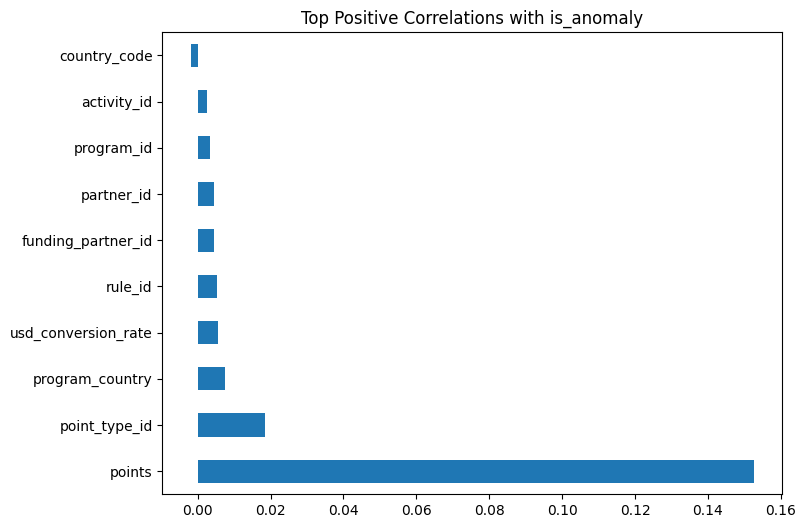

In [60]:
plt.figure(figsize=(8,6))
corr_with_target_r.drop("is_anomaly").head(10).plot(kind="barh")
plt.title("Top Positive Correlations with is_anomaly")
plt.show()

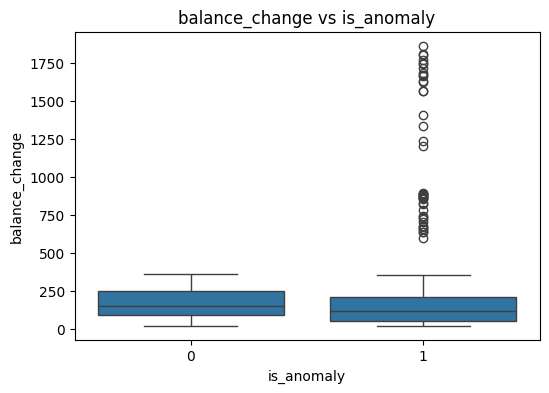

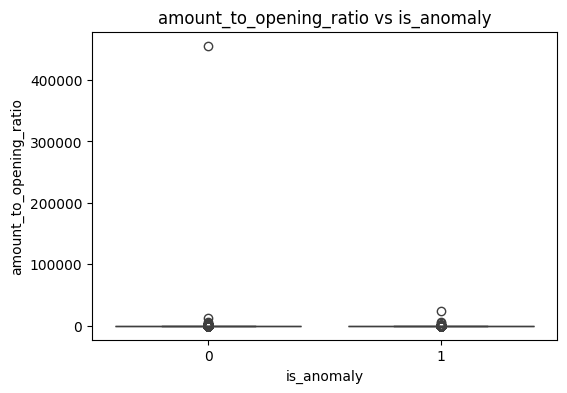

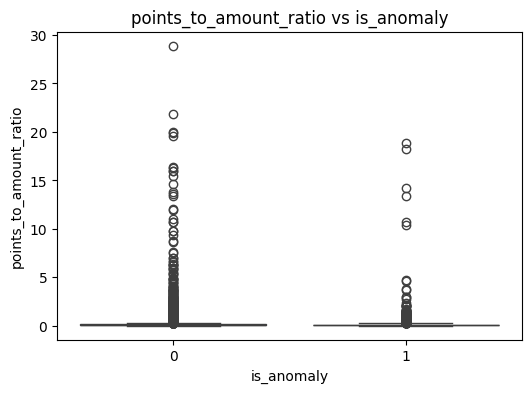

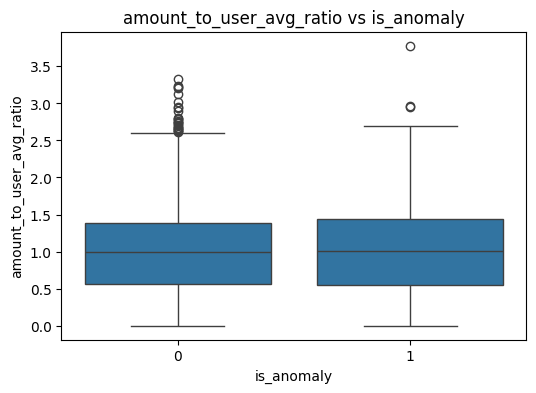

In [66]:
accu_df["balance_change"] = accu_df["closing_balance"] - accu_df["opening_balance"]
redm_df["balance_change"] = redm_df["closing_balance"] - redm_df["opening_balance"]

accu_df["amount_to_opening_ratio"] = np.where(
    accu_df["opening_balance"] != 0,
    accu_df["amount"] / accu_df["opening_balance"],
    0
)

redm_df["amount_to_opening_ratio"] = np.where(
    redm_df["opening_balance"] != 0,
    redm_df["amount"] / redm_df["opening_balance"],
    0
)

accu_df["points_to_amount_ratio"] = np.where(
    accu_df["amount"] != 0,
    accu_df["points"] / accu_df["amount"],
    0
)

redm_df["points_to_amount_ratio"] = np.where(
    redm_df["amount"] != 0,
    redm_df["points"] / redm_df["amount"],
    0
)

user_avg_amount = accu_df.groupby("customer_unique_id")["amount"].transform("mean")

accu_df["amount_to_user_avg_ratio"] = np.where(
    user_avg_amount != 0,
    accu_df["amount"] / user_avg_amount,
    0
)

user_avg_amount = redm_df.groupby("customer_unique_id")["amount"].transform("mean")

redm_df["amount_to_user_avg_ratio"] = np.where(
    user_avg_amount != 0,
    redm_df["amount"] / user_avg_amount,
    0
)

new_features = [
    "balance_change",
    "amount_to_opening_ratio",
    "points_to_amount_ratio",
    "amount_to_user_avg_ratio"
]

for col in new_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="is_anomaly", y=col, data=accu_df)
    plt.title(f"{col} vs is_anomaly")
    plt.show()

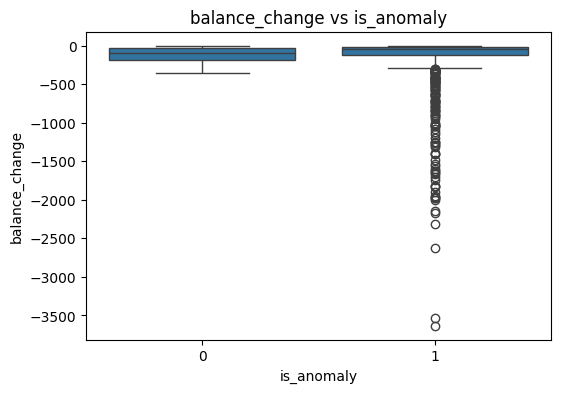

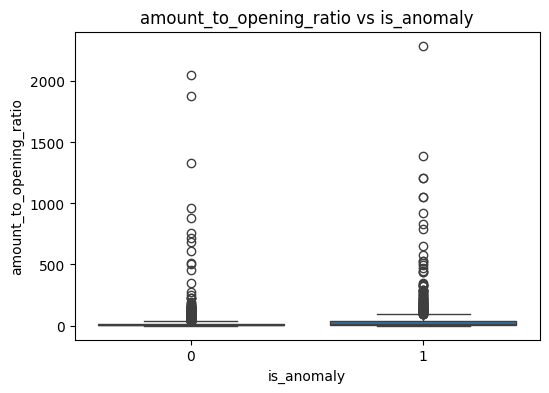

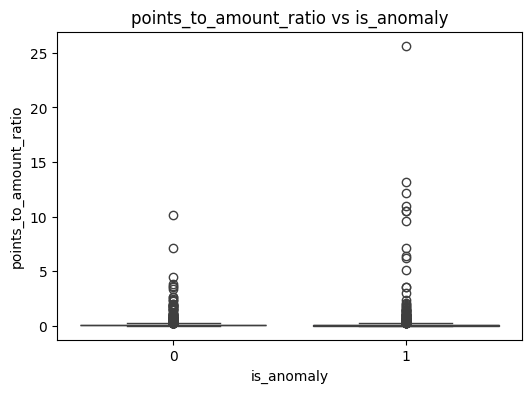

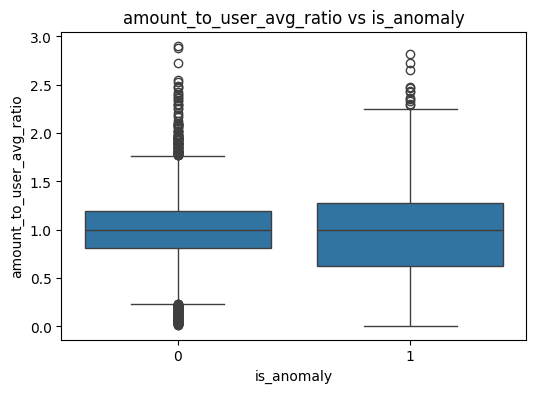

In [67]:
for col in new_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="is_anomaly", y=col, data=redm_df)
    plt.title(f"{col} vs is_anomaly")
    plt.show()

### Per user behaviour

customer_unique_id
0006417714fe4a78913920f39a03cdf7     5
00176d354809434aaf55a54ce87ed2dc     2
001a7b9e46d24548a234519499a5c40e     2
002a724f12d7491a94fbb62ae93a377a     5
002cc23bffa546f1b6135d696f7ee2f8     6
                                    ..
ff7990dd62ce4da28dc66491d7f2255e    11
ff850a3f7a8d409292930fbeb0479412     2
ffad86536b4c44f4aa9363352282c6b4     5
ffb2c52e8b8d4238a0637239265075ad     5
ffd7b397a72b4a9cb3205aa367bc6c8c     1
Name: transaction_id, Length: 1741, dtype: int64


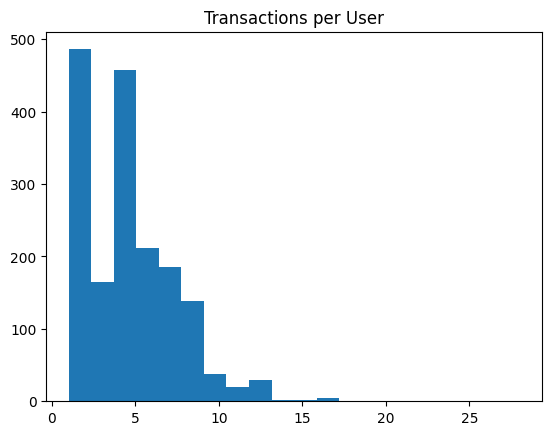

In [43]:
user_txn_count = accu_df.groupby("customer_unique_id")["transaction_id"].count()
print(user_txn_count)
plt.hist(user_txn_count, bins=20)
plt.title("Transactions per User")
plt.show()

customer_unique_id
0006417714fe4a78913920f39a03cdf7    2
002cc23bffa546f1b6135d696f7ee2f8    4
0044296b9afd432f99122451afd516a8    1
005e69376c054aa392790b32de618d9a    1
0074e25ea6aa411ba26a66dda6ef7c44    3
                                   ..
fe9f554bd62046048f94faee3171144e    2
ff7990dd62ce4da28dc66491d7f2255e    1
ffad86536b4c44f4aa9363352282c6b4    3
ffb2c52e8b8d4238a0637239265075ad    4
ffd7b397a72b4a9cb3205aa367bc6c8c    1
Name: transaction_id, Length: 1141, dtype: int64


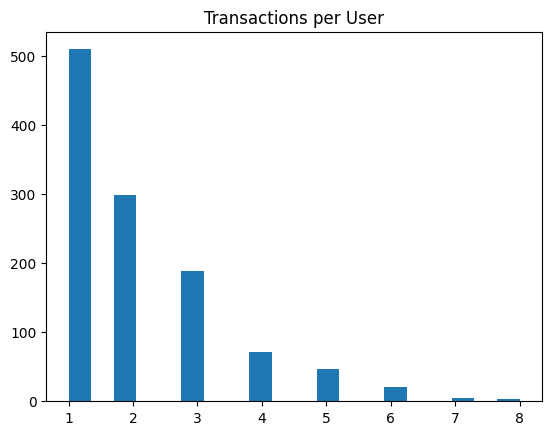

In [44]:
user_txn_count = redm_df.groupby("customer_unique_id")["transaction_id"].count()
print(user_txn_count)
plt.hist(user_txn_count, bins=20)
plt.title("Transactions per User")
plt.show()

### Fraud per user

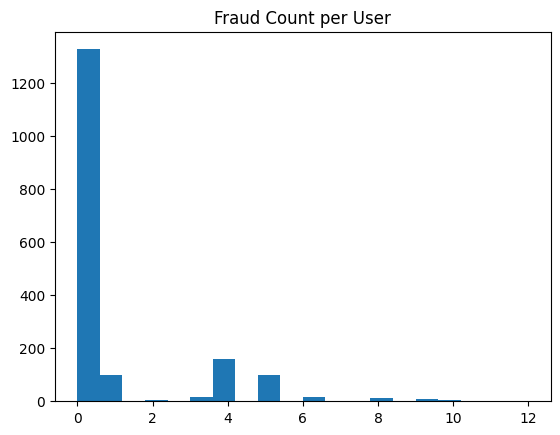

In [45]:
fraud_per_user = accu_df.groupby("customer_unique_id")["is_anomaly"].sum()

plt.hist(fraud_per_user, bins=20)
plt.title("Fraud Count per User")
plt.show()

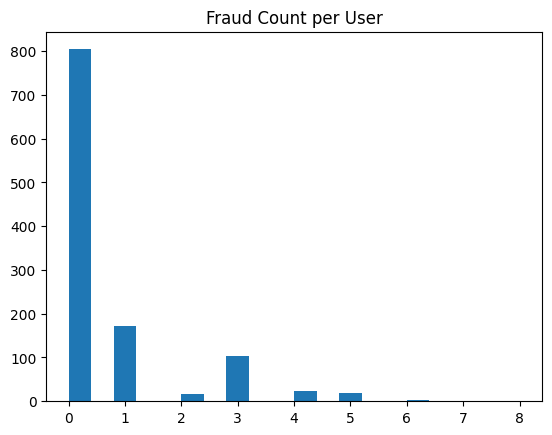

In [47]:
fraud_per_user = redm_df.groupby("customer_unique_id")["is_anomaly"].sum()

plt.hist(fraud_per_user, bins=20)
plt.title("Fraud Count per User")
plt.show()


### Fraud vs Not-fraud

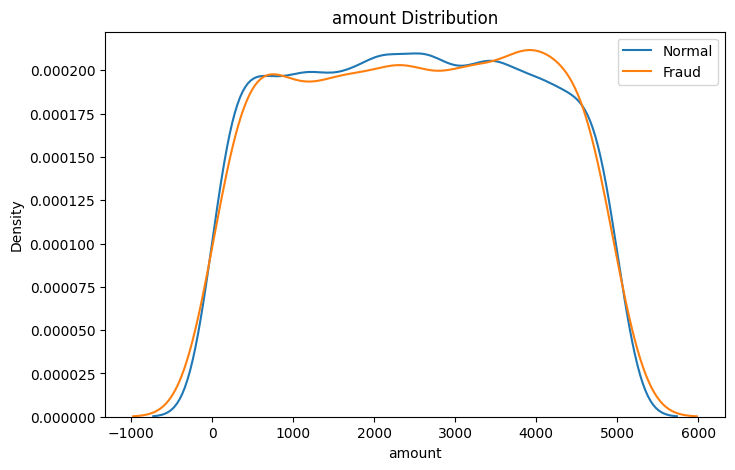

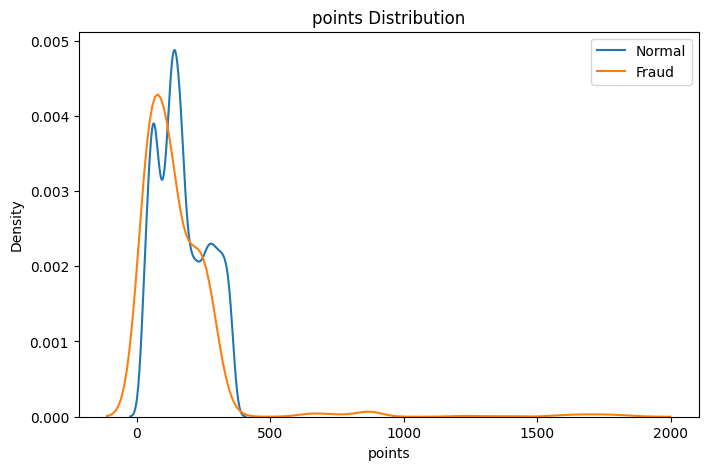

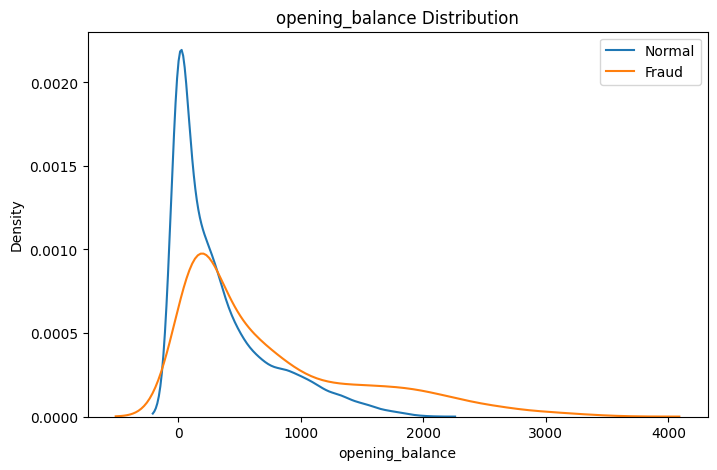

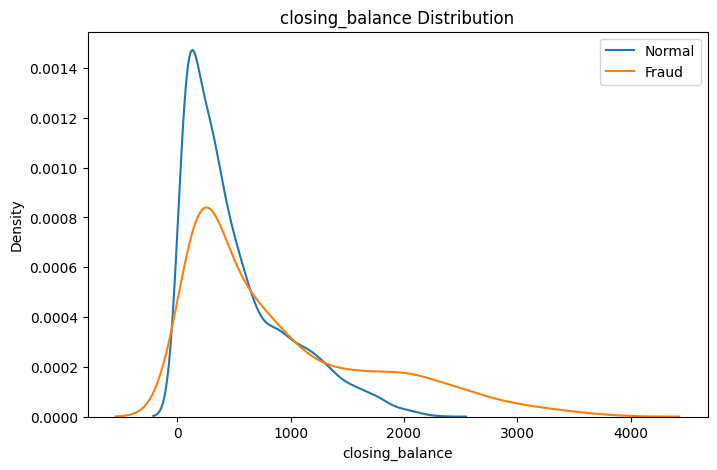

In [50]:
num_cols = ["amount", "points", "opening_balance", "closing_balance"]

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=accu_df[accu_df["is_anomaly"]==0], x=col, label="Normal")
    sns.kdeplot(data=accu_df[accu_df["is_anomaly"]==1], x=col, label="Fraud")
    plt.title(f"{col} Distribution")
    plt.legend()
    plt.show()

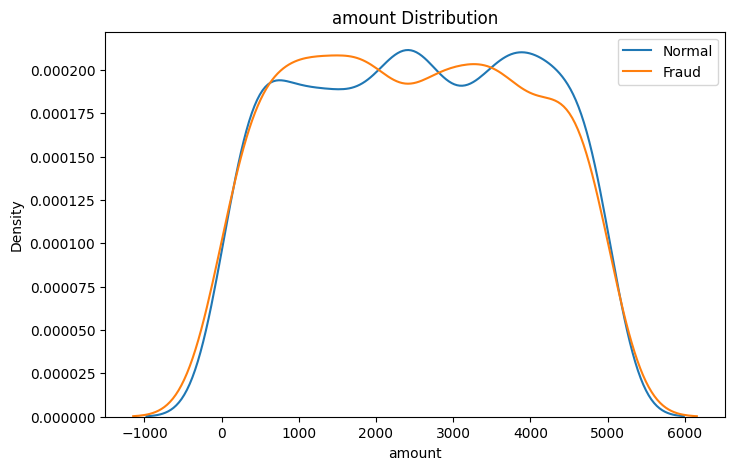

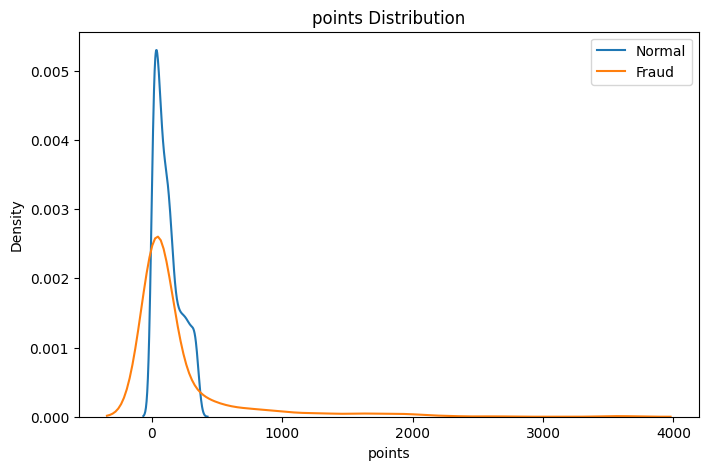

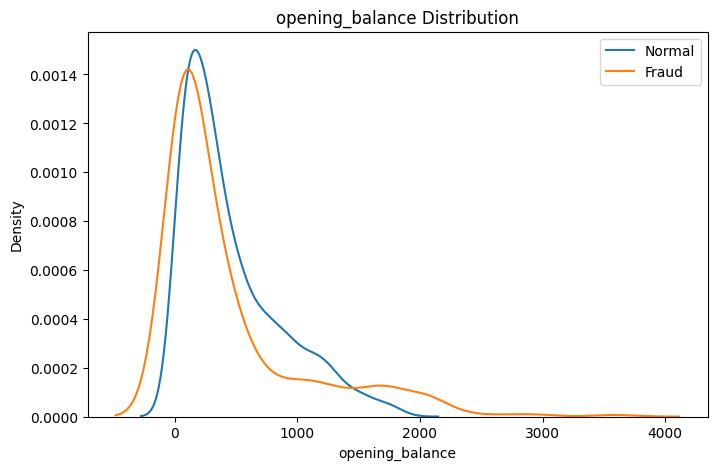

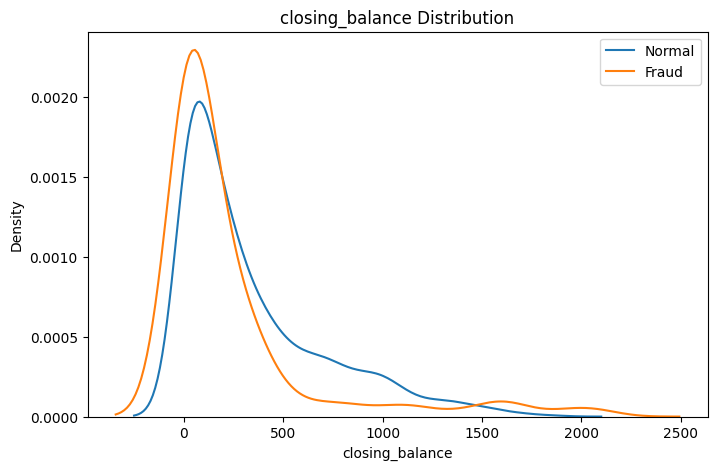

In [54]:
num_cols = ["amount", "points", "opening_balance", "closing_balance"]

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=redm_df[redm_df["is_anomaly"]==0], x=col, label="Normal")
    sns.kdeplot(data=redm_df[redm_df["is_anomaly"]==1], x=col, label="Fraud")
    plt.title(f"{col} Distribution")
    plt.legend()
    plt.show()

### Target Variable Analysis

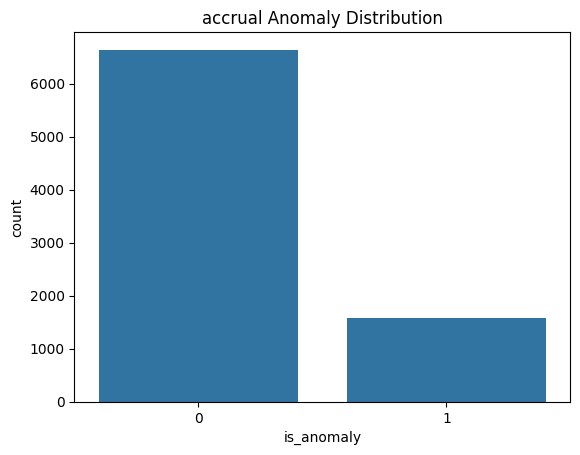

In [24]:
accu_df["is_anomaly"].value_counts()

sns.countplot(x="is_anomaly", data=accu_df)
plt.title("accrual Anomaly Distribution")
plt.show()


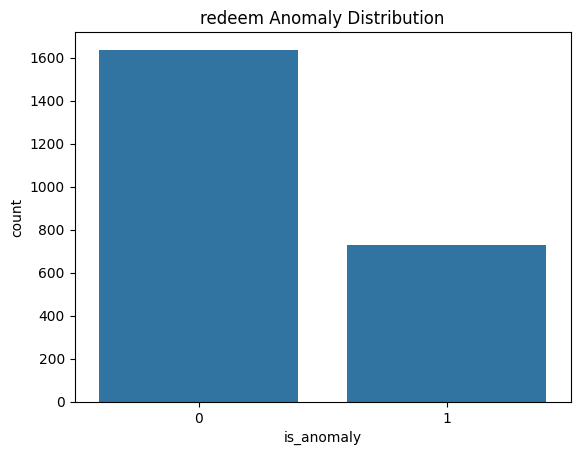

In [23]:
redm_df["is_anomaly"].value_counts()

sns.countplot(x="is_anomaly", data=redm_df)
plt.title("redeem Anomaly Distribution")
plt.show()


### Country vs Fraud

In [51]:
print(accu_df["country_code"].unique())
print(accu_df["country_code"].unique())

[971  91  65   1]
[971  91  65   1]


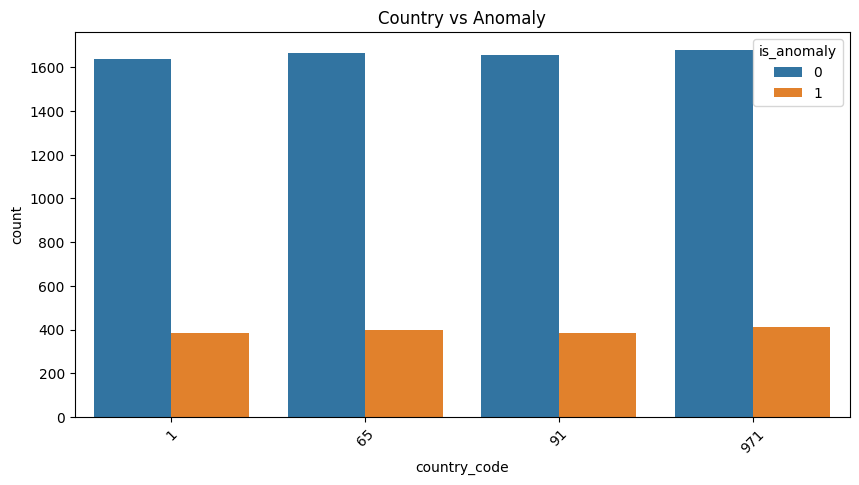

In [52]:
plt.figure(figsize=(10,5))
sns.countplot(data=accu_df, x="country_code", hue="is_anomaly")
plt.xticks(rotation=45)
plt.title("Country vs Anomaly")
plt.show()

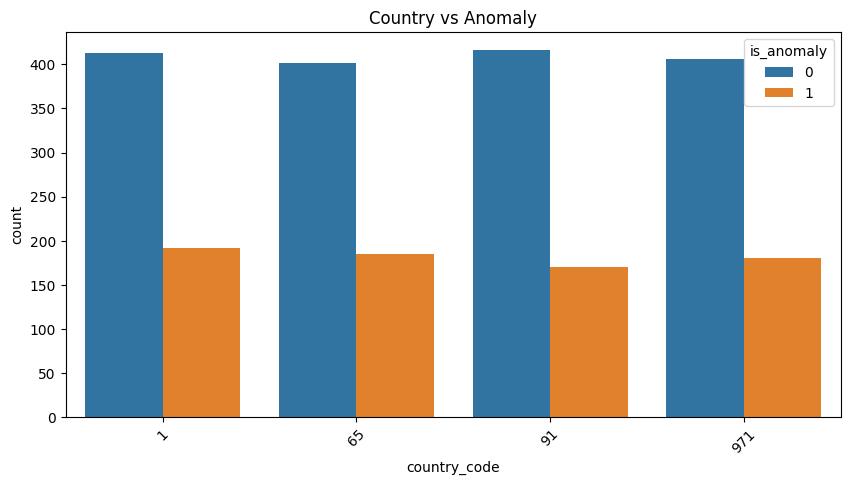

In [53]:
plt.figure(figsize=(10,5))
sns.countplot(data=redm_df, x="country_code", hue="is_anomaly")
plt.xticks(rotation=45)
plt.title("Country vs Anomaly")
plt.show()

### Preprocessing

In [ ]:
accu_final_df = preprocessing(accu_df)
redm_final_df = preprocessing(redm_df)

In [69]:
accu_final_df.columns

Index(['transaction_type', 'points', 'partner_id', 'opening_balance',
       'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity',
       'payment_type', 'program_id', 'program_country', 'program_currency',
       'base_currency', 'trans_currency', 'conversion_rate',
       'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd',
       'channel_code', 'point_expiry', 'point_type_id', 'calculated_amount',
       'hours', 'day_of_week', 'is_weekend', 'balance_change',
       'amount_to_opening_ratio', 'points_to_amount_ratio'],
      dtype='str')

In [70]:
redm_final_df.columns

Index(['transaction_type', 'points', 'partner_id', 'opening_balance',
       'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity',
       'payment_type', 'program_id', 'program_country', 'program_currency',
       'base_currency', 'trans_currency', 'conversion_rate',
       'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd',
       'channel_code', 'point_expiry', 'point_type_id', 'calculated_amount',
       'hours', 'day_of_week', 'is_weekend', 'balance_change',
       'amount_to_opening_ratio', 'points_to_amount_ratio'],
      dtype='str')

In [ ]:
accu_final_df.head()

,transaction_type,points,partner_id,opening_balance,closing_balance,amount,is_anomaly,country_code,quantity,payment_type,...,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,point_type_id,calculated_amount,hours,day_of_week,is_weekend
0,earn,333.09,439,0.00,333.09,2307.33,0,971,6,CASH,...,1554.45,0.0805,185.74,CPN,2023-06-05 07:30:00.000000,9,2217.93,7,4,0
1,earn,314.54,439,333.09,647.63,4863.34,0,91,7,CASH,...,4465.03,0.0969,471.26,CPN,2024-11-02 06:19:00.000000,13,4883.89,6,6,1
2,earn,341.69,212,647.63,989.32,644.58,0,65,9,CARD,...,404.80,0.0687,44.28,POS,2023-12-29 10:06:00.000000,19,604.63,10,0,0
3,earn,274.21,439,660.26,934.47,3202.35,0,91,4,WALLET,...,3650.68,0.0767,245.62,POS,2024-10-30 08:48:00.000000,15,3627.60,8,2,0
4,earn,350.79,439,885.07,1235.86,4056.82,0,91,6,CARD,...,4945.26,0.0618,250.71,CPN,2023-12-27 08:15:00.000000,3,4557.73,8,4,0


In [20]:
redm_final_df.head()

,transaction_type,points,partner_id,opening_balance,closing_balance,amount,is_anomaly,country_code,quantity,payment_type,...,amount_in_trans_currency,usd_conversion_rate,amount_in_usd,channel_code,point_expiry,point_type_id,calculated_amount,hours,day_of_week,is_weekend
0,redeem,329.06,439,989.32,660.26,2309.53,0,1,8,CASH,...,3498.25,0.0457,105.55,CPN,2024-12-22 06:39:00.000000,18,2016.54,6,1,0
1,redeem,49.40,439,934.47,885.07,2484.20,0,1,1,UPI,...,2068.84,0.0509,126.45,CPN,2024-05-12 11:57:00.000000,7,2087.11,11,3,0
2,redeem,312.96,435,459.79,146.83,1893.40,0,1,5,WALLET,...,2182.90,0.0495,93.72,POS,2024-07-24 19:05:00.000000,7,1596.01,19,0,0
3,redeem,37.73,435,740.86,703.13,4298.60,0,971,5,CASH,...,3864.01,0.0794,341.31,POS,2023-10-18 21:39:00.000000,1,4166.84,21,4,0
4,redeem,87.01,435,703.13,616.12,4442.77,0,65,6,CARD,...,8400.39,0.0416,184.82,CPN,2023-04-11 19:38:00.000000,14,3787.68,19,6,1


In [ ]:
numeric_cols_a = accu_final_df.select_dtypes(include=np.number)

corr_with_target_a = numeric_cols_a.corr()["is_anomaly"].sort_values(ascending=False)

print(corr_with_target_a)

is_anomaly                  1.000000
opening_balance             0.314204
closing_balance             0.275034
is_weekend                  0.027941
partner_id                  0.018009
day_of_week                 0.017772
amount_in_usd               0.012625
amount_in_trans_currency    0.011069
quantity                    0.010194
country_code                0.007995
point_type_id               0.007969
calculated_amount           0.006574
amount                      0.006337
usd_conversion_rate         0.001761
conversion_rate            -0.001584
program_id                 -0.003677
program_country            -0.003881
points                     -0.045365
hours                      -0.063433
Name: is_anomaly, dtype: float64


In [63]:
numeric_cols_a = redm_final_df.select_dtypes(include=np.number)

corr_with_target_a = numeric_cols_a.corr()["is_anomaly"].sort_values(ascending=False)

print(corr_with_target_a)

is_anomaly                  1.000000
points                      0.152733
point_type_id               0.018352
program_country             0.007526
hours                       0.006122
usd_conversion_rate         0.005515
partner_id                  0.004415
program_id                  0.003498
is_weekend                 -0.001620
country_code               -0.001930
day_of_week                -0.002837
conversion_rate            -0.008333
amount_in_usd              -0.009829
opening_balance            -0.015567
amount_in_trans_currency   -0.017034
quantity                   -0.019084
amount                     -0.021727
calculated_amount          -0.024140
closing_balance            -0.119369
Name: is_anomaly, dtype: float64


### Amount vs Fraud

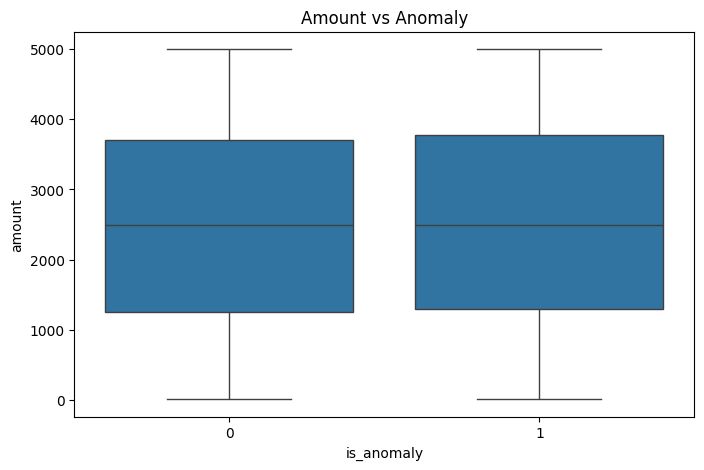

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_anomaly", y="amount", data=accu_final_df)
plt.title("Amount vs Anomaly")
plt.show()

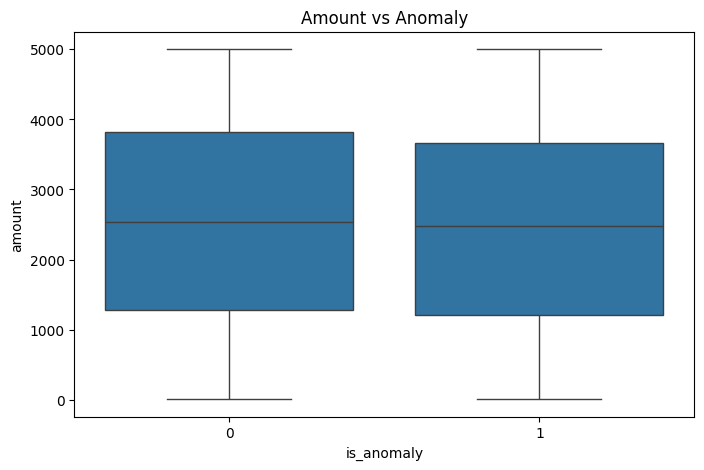

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_anomaly", y="amount", data=redm_final_df)
plt.title("Amount vs Anomaly")
plt.show()

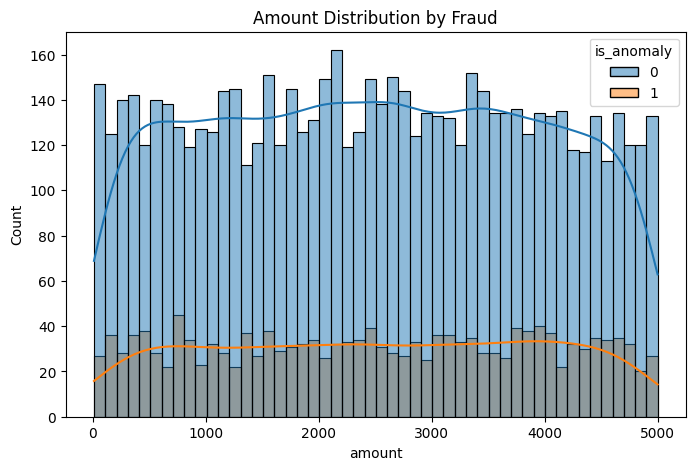

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=accu_final_df, x="amount", hue="is_anomaly", bins=50, kde=True)
plt.title("Amount Distribution by Fraud")
plt.show()


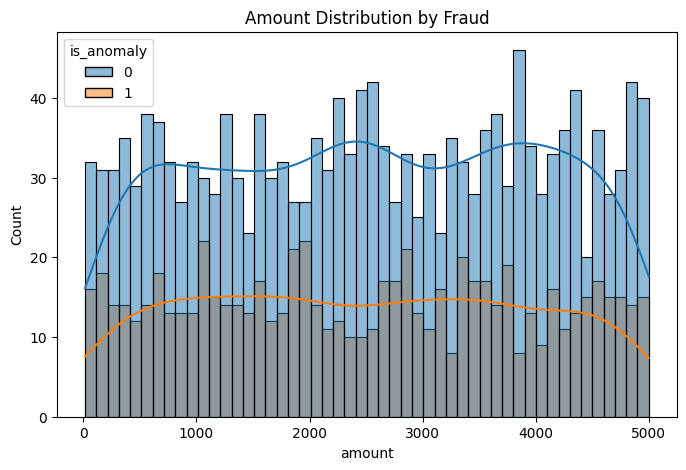

In [28]:
plt.figure(figsize=(8,5))
sns.histplot(data=redm_final_df, x="amount", hue="is_anomaly", bins=50, kde=True)
plt.title("Amount Distribution by Fraud")
plt.show()

### Points vs Fraud

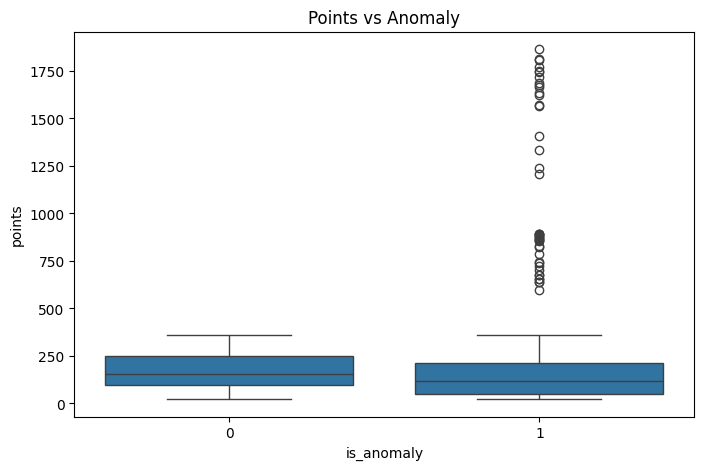

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_anomaly", y="points", data=accu_final_df)
plt.title("Points vs Anomaly")
plt.show()

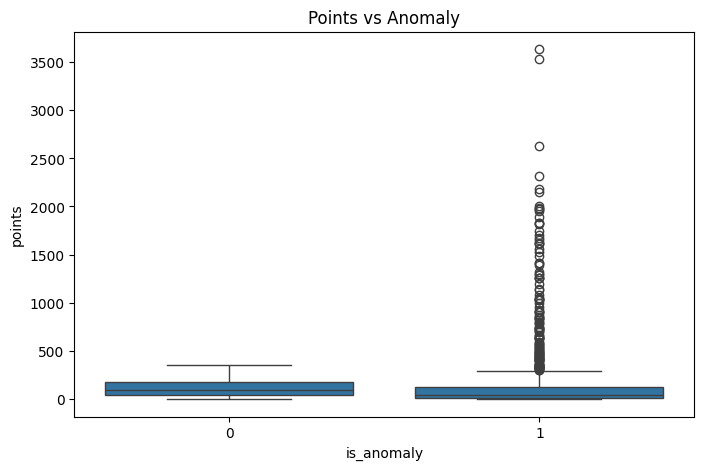

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(x="is_anomaly", y="points", data=redm_final_df)
plt.title("Points vs Anomaly")
plt.show()

### Categorical features vs fraud

In [ ]:
print(accu_final_df["channel_code"].unique())
print(redm_final_df["channel_code"].unique())

<StringArray>
['CPN', 'POS']
Length: 2, dtype: str
<StringArray>
['CPN', 'POS']
Length: 2, dtype: str


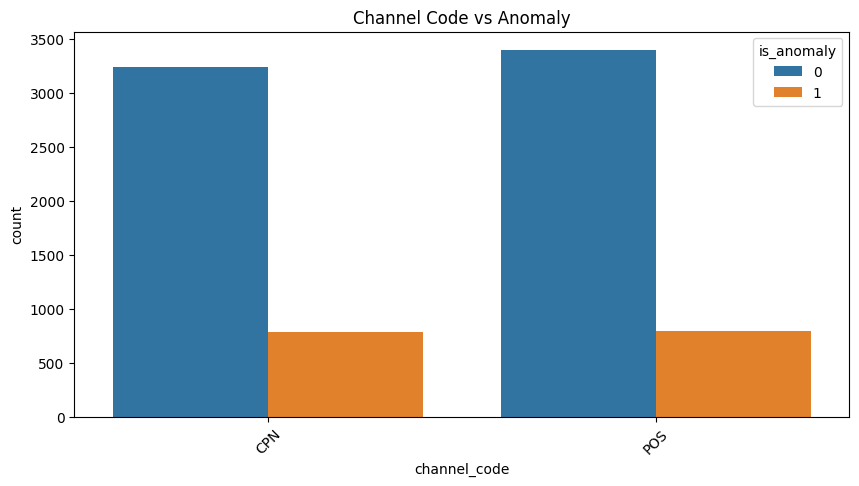

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=accu_final_df, x="channel_code", hue="is_anomaly")
plt.xticks(rotation=45)
plt.title("Channel Code vs Anomaly")
plt.show()

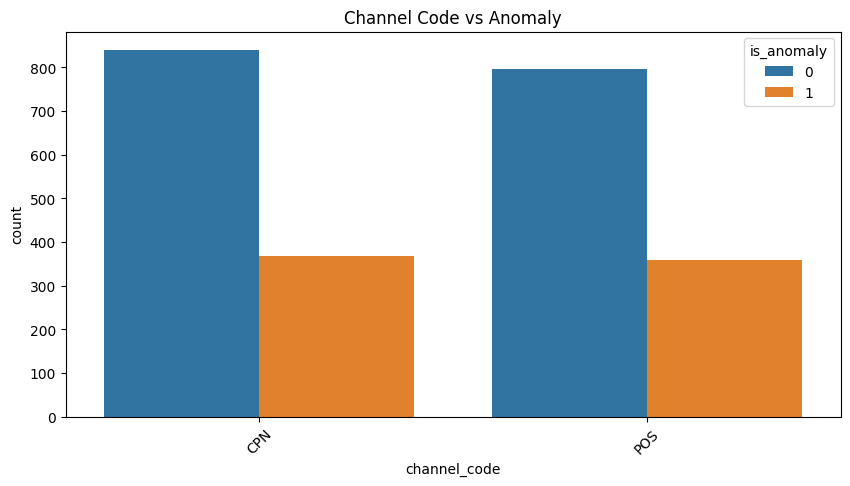

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(data=redm_final_df, x="channel_code", hue="is_anomaly")
plt.xticks(rotation=45)
plt.title("Channel Code vs Anomaly")
plt.show()

### Country vs Fraud

In [ ]:
print(accu_final_df["country_code"].unique())
print(redm_final_df["country_code"].unique())

[971  91  65   1]
[971  91  65   1]


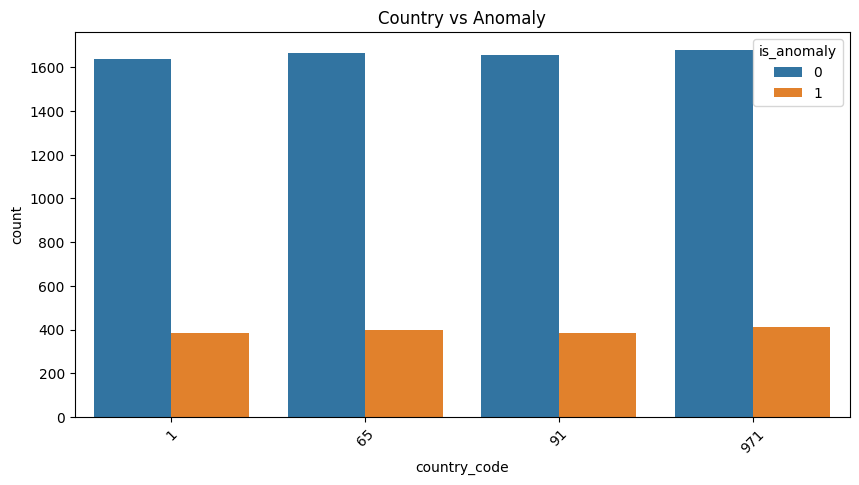

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=accu_final_df, x="country_code", hue="is_anomaly")
plt.xticks(rotation=45)
plt.title("Country vs Anomaly")
plt.show()

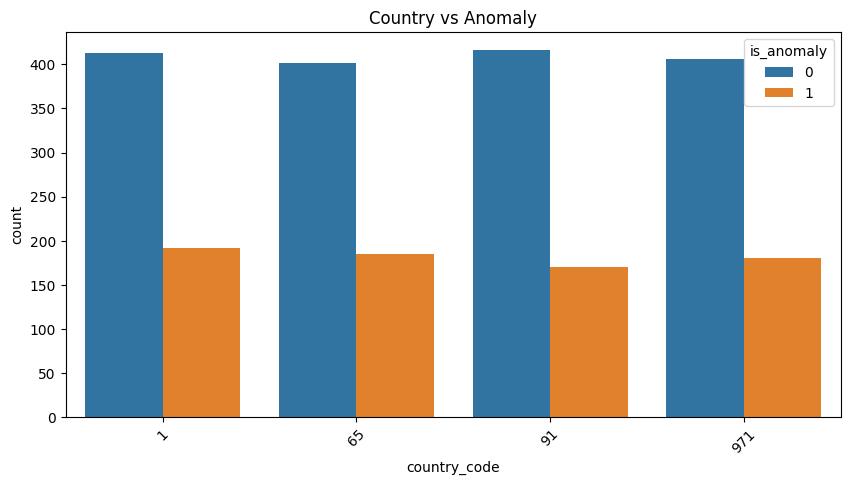

In [35]:
plt.figure(figsize=(10,5))
sns.countplot(data=redm_final_df, x="country_code", hue="is_anomaly")
plt.xticks(rotation=45)
plt.title("Country vs Anomaly")
plt.show()

### Based on hour of the day

In [ ]:
accu_final_df.columns

Index(['transaction_type', 'points', 'partner_id', 'opening_balance',
       'closing_balance', 'amount', 'is_anomaly', 'country_code', 'quantity',
       'payment_type', 'program_id', 'program_country', 'program_currency',
       'base_currency', 'trans_currency', 'conversion_rate',
       'amount_in_trans_currency', 'usd_conversion_rate', 'amount_in_usd',
       'channel_code', 'point_expiry', 'point_type_id', 'calculated_amount',
       'hours', 'day_of_week', 'is_weekend'],
      dtype='str')

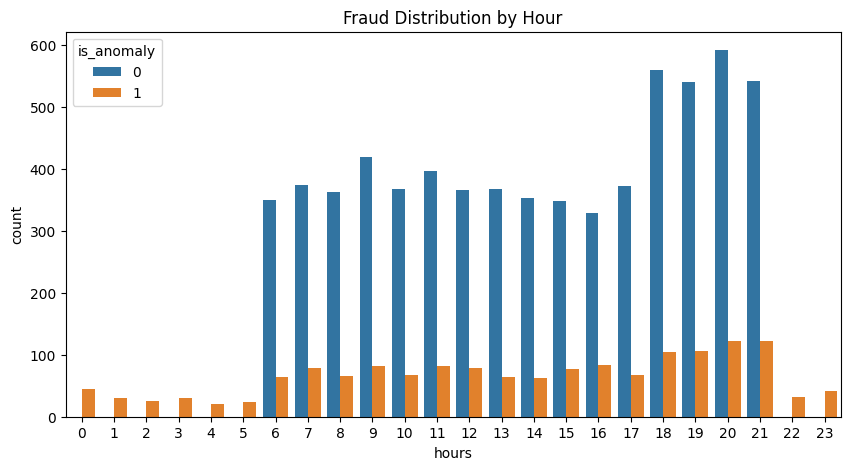

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=accu_final_df, x="hours", hue="is_anomaly")
plt.title("Fraud Distribution by Hour")
plt.show()


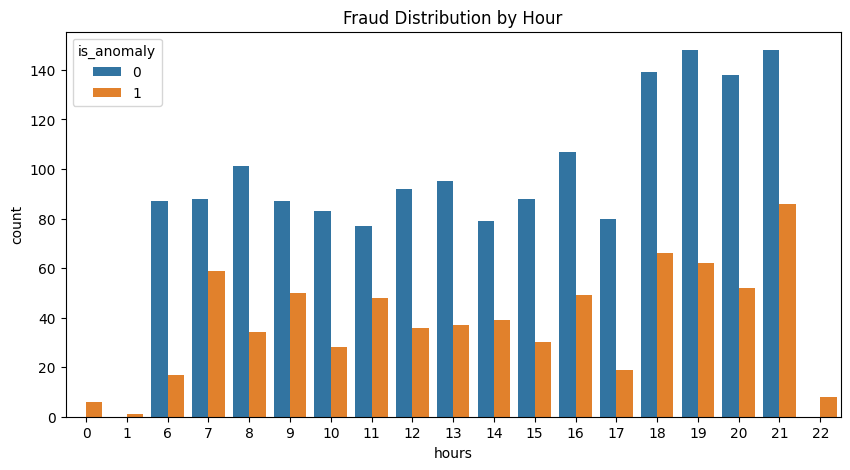

In [40]:
plt.figure(figsize=(10,5))
sns.countplot(data=redm_final_df, x="hours", hue="is_anomaly")
plt.title("Fraud Distribution by Hour")
plt.show()

# Train Accrual Model

### train accural DF

In [10]:
accu_model, accu_y_test, accu_y_pred, accu_y_prob = training(accu_df)

### Printing metrics

In [11]:
metrics(accu_y_test, accu_y_pred, accu_y_prob)


Model Metrics
ROC AUC: 0.9311780349245082
Gini: 0.8623560698490165
KS: 0.7065254689644654
PR AUC: 0.8326202378010937
F1: 0.6508313539192399
Precision: 0.5209125475285171
Recall: 0.8670886075949367
Confusion Matrix:
 [[1076  252]
 [  42  274]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1328
           1       0.52      0.87      0.65       316

    accuracy                           0.82      1644
   macro avg       0.74      0.84      0.77      1644
weighted avg       0.88      0.82      0.84      1644



### Printing decile

In [ ]:
accu_result_df = decile_cal(accu_y_test, accu_y_prob, accu_y_pred)


Non-Anomalies Distribution
                Count      %
severity                    
Very High Risk      6   0.45
High Risk         218  16.42
Medium Risk       453  34.11
Low Risk          651  49.02

Anomalies Distribution
                Count      %
severity                    
Very High Risk    159  50.32
High Risk         110  34.81
Medium Risk        40  12.66
Low Risk            7   2.22

Decile Performance Table
        total  bad  bad_rate
decile                      
D1        165    1    0.0061
D10       165  159    0.9636
D2        164    1    0.0061
D3        164    3    0.0183
D4        165    2    0.0121
D5        164    3    0.0183
D6        164   12    0.0732
D7        165   25    0.1515
D8        164   37    0.2256
D9        164   73    0.4451


In [ ]:
accu_result_df

,actual,probability,predicted,decile,severity
0,0,0.914159,1,D9,High Risk
1,1,0.558555,1,D9,High Risk
2,1,0.326256,1,D7,Medium Risk
3,0,0.214180,0,D7,Medium Risk
4,0,0.242223,0,D7,Medium Risk
...,...,...,...,...,...
1639,1,0.999498,1,D10,Very High Risk
1640,1,0.581662,1,D9,High Risk
1641,0,0.005640,0,D1,Low Risk
1642,0,0.029544,0,D3,Low Risk


# Train Redemption Model

### train redemption DF

In [12]:
redm_model, redm_y_test, redm_y_pred, redm_y_prob = training(redm_df)

### Printing Metrics

In [13]:
metrics(redm_y_test, redm_y_pred, redm_y_prob)


Model Metrics
ROC AUC: 0.8132884777123633
Gini: 0.6265769554247267
KS: 0.4915685449957948
PR AUC: 0.673933933492401
F1: 0.6208530805687204
Precision: 0.4729241877256318
Recall: 0.903448275862069
Confusion Matrix:
 [[182 146]
 [ 14 131]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.55      0.69       328
           1       0.47      0.90      0.62       145

    accuracy                           0.66       473
   macro avg       0.70      0.73      0.66       473
weighted avg       0.79      0.66      0.67       473



### Printing Decile

In [51]:
redm_result_df = decile_cal(redm_y_test, redm_y_prob, redm_y_pred)


Non-Anomalies Distribution
                Count      %
severity                    
Very High Risk     10   3.05
High Risk          48  14.63
Medium Risk        92  28.05
Low Risk          178  54.27

Anomalies Distribution
                Count      %
severity                    
Very High Risk     38  26.21
High Risk          46  31.72
Medium Risk        50  34.48
Low Risk           11   7.59

Decile Performance Table
        total  bad  bad_rate
decile                      
D1         48    1    0.0208
D10        48   38    0.7917
D2         47    2    0.0426
D3         47    2    0.0426
D4         47    6    0.1277
D5         48   14    0.2917
D6         47   19    0.4043
D7         47   17    0.3617
D8         47   23    0.4894
D9         47   23    0.4894


In [56]:
redm_result_df

,actual,probability,predicted,decile,severity
0,1,0.860124,1,D10,Very High Risk
1,0,0.415781,1,D6,Medium Risk
2,0,0.831409,1,D10,Very High Risk
3,0,0.141843,0,D3,Low Risk
4,0,0.133444,0,D2,Low Risk
...,...,...,...,...,...
468,0,0.075949,0,D1,Low Risk
469,1,0.945200,1,D10,Very High Risk
470,0,0.467377,1,D7,Medium Risk
471,0,0.285566,0,D4,Low Risk


# Graphs

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_decile_distribution(result_df, title="Risk Distribution by Decile"):

    # Ensure proper decile order
    decile_order = [f"D{i}" for i in range(1, 11)]

    # Build summary table
    bin_summary = (
        result_df.groupby(["decile", "actual"])
        .size()
        .unstack(fill_value=0)
        .reindex(decile_order)
    )

    bin_summary["total"] = bin_summary[0] + bin_summary[1]
    bin_summary["bad_rate"] = (
        bin_summary[1] / bin_summary["total"]
    ).round(4)

    bin_summary = bin_summary.reset_index()

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(10,6))

    bars_good = plt.bar(
        range(len(bin_summary)),
        bin_summary[0],
        label="Good",
        color="skyblue"
    )

    bars_bad = plt.bar(
        range(len(bin_summary)),
        bin_summary[1],
        bottom=bin_summary[0],
        label="Bad",
        color="orange"
    )

    # Add labels
    for i in range(len(bin_summary)):
        if bin_summary[0][i] > 0:
            plt.text(
                i,
                bin_summary[0][i] / 2,
                f"{bin_summary[0][i]}",
                ha="center",
                va="center",
                fontsize=9
            )

        if bin_summary[1][i] > 0:
            plt.text(
                i,
                bin_summary[0][i] + bin_summary[1][i] / 2,
                f"{bin_summary[1][i]}",
                ha="center",
                va="center",
                fontsize=9
            )

    plt.xticks(range(len(bin_summary)), decile_order)
    plt.xlabel("Risk Score Deciles (Low → High Risk)")
    plt.ylabel("Number of Customers")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", alpha=0.3)

    plt.show()

    return bin_summary

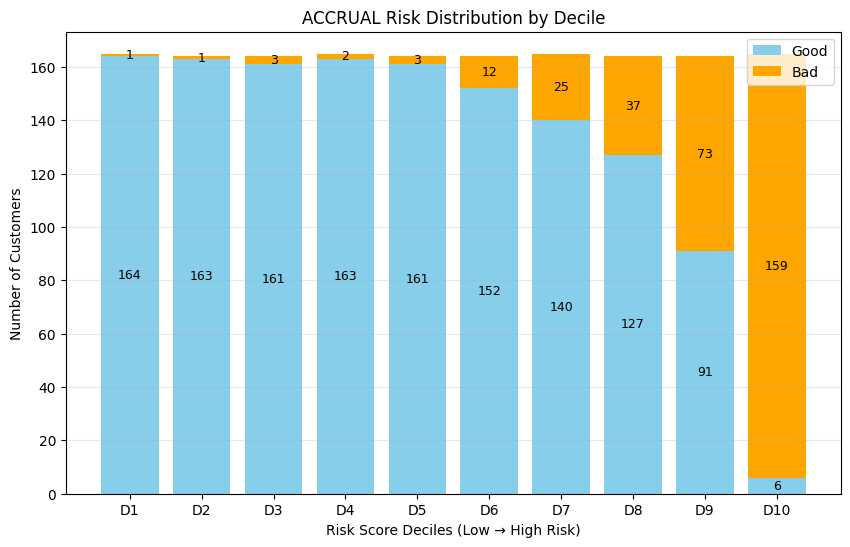

In [53]:
accu_summary = plot_decile_distribution(accu_result_df, title="ACCRUAL Risk Distribution by Decile")

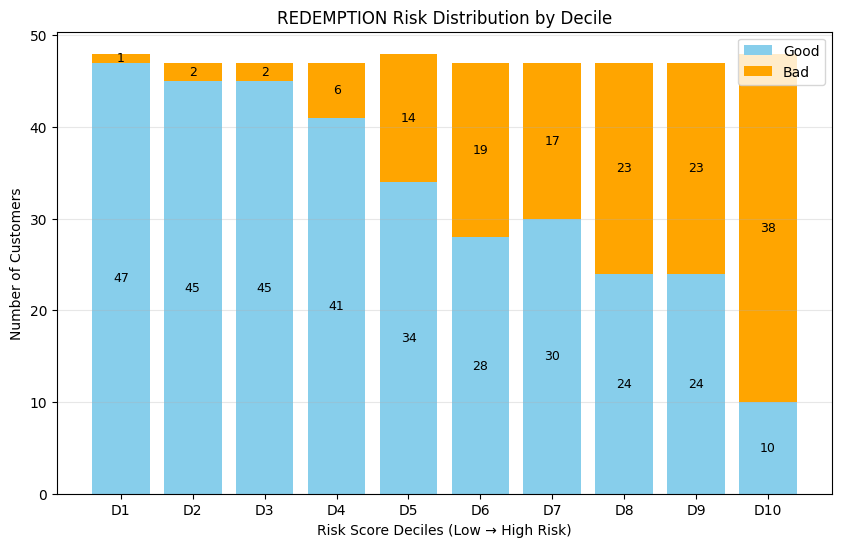

In [54]:
redm_summary = plot_decile_distribution(redm_result_df, title="REDEMPTION Risk Distribution by Decile")